In [1]:
import tensorflow as tf


# Fetch images

The test data is from the [EPFL CVLAB data repository](https://www.epfl.ch/labs/cvlab/data/data-em/).
Download the images from 
![](FIBSLICE0035_left_top.png)
||Input| Ground truth|
|---|---|---|
|Training|[Training](https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training.tif)|[Training ground truth](https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training_groundtruth.tif)|
|Testing|[Testing](https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/testing.tif)|[Testing ground truth](https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/testing_groundtruth.tif)|

# Prepare images for training
The images are stored as multi frame tiff and are too large for our demo.
We have to:
- load some frames. E.g. every 10 images. 
- crop to realistic size


In [38]:
from PIL import Image

def crop_and_convert(tiff_path, dest_mask,first=0, step=1, crop_box=None) :
    
    tiff_image = Image.open(tiff_path)

    # Iterate through each frame
    frame_number = first
    filelist = []
    while True:
        try:
            tiff_image.seek(frame_number)
            # Process the current frame
            
            # For example, you can save each frame as a separate image
            fname = dest_mask.format(frame_number)
            filelist.append(fname)
            
            if crop_box is None :
#                 print(f"Processing full frame {frame_number}")
                tiff_image.save(fname)
            else :
#                 print(f"Processing cropped frame {frame_number}")
                cropped_frame = tiff_image.crop(crop_box)
                # Save the cropped frame
                cropped_frame.save(fname)
            
            frame_number += step
        except EOFError:
            # No more frames in the TIFF file
#             print('done')
            break
    return filelist
            


In [221]:
train_image_paths = crop_and_convert('training.tif', 'training_{0:04d}.png',step=20,crop_box=[256,256,768,768])
train_mask_paths  = crop_and_convert('training_groundtruth.tif', 'trainingGT_{0:04d}.png',step=20,crop_box=[256,256,768,768])

In [87]:
def parse_image_function(image_path, mask_path, img_size=(128, 128), channels=3):
    # Load and preprocess the input image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=channels)
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0

    # Load and preprocess the corresponding mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, img_size)
    mask = tf.cast(mask, tf.float32) / 255.0  # For binary masks
    return image, mask

In [88]:
# Suppose you have lists of image and mask file paths:
# train_image_paths = [...]  # list of file paths to training images
# train_mask_paths  = [...]  # list of file paths to corresponding masks

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
train_dataset = train_dataset.map(lambda img, msk: parse_image_function(img, msk),
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

In [89]:
from tensorflow.keras import layers, models

def unet_model(input_shape=(128, 128, 3), num_classes=1):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3,3), activation='relu', padding='same')(c3)

    # Decoder
    u2 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c3)
    u2 = layers.concatenate([u2, c2])
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c4)

    u1 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c4)
    u1 = layers.concatenate([u1, c1])
    c5 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c5)

    # Output layer: for binary segmentation use a sigmoid; for multi-class, use softmax
    outputs = layers.Conv2D(num_classes, (1,1), activation='sigmoid')(c5)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate and compile the model
model = unet_model()
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # change loss if needed (e.g., categorical_crossentropy for multi-class)
              metrics=['accuracy'])

model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_55[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 64, 64,    │          0 │ conv2d_56[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_57[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 32, 32,    │          0 │ conv2d_58[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_11… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_59[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_10 │ (None, 64, 64,    │    131,200 │ conv2d_60[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_58[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 64, 64,    │    295,040 │ concatenate_10[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_61[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_11 │ (None, 128, 128,  │     32,832 │ conv2d_62[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_56[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 128, 128,  │     73,792 │ concatenate_11[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_63[0][0] 

 Total params: 1,862,849 (7.11 MB)

 Trainable params: 1,862,849 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

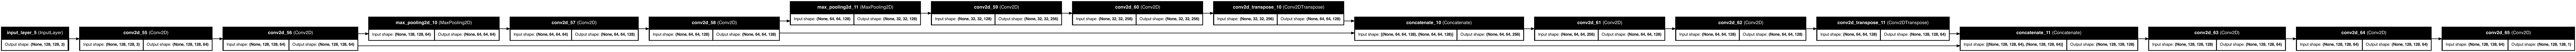

In [90]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your TensorFlow/Keras model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='LR')



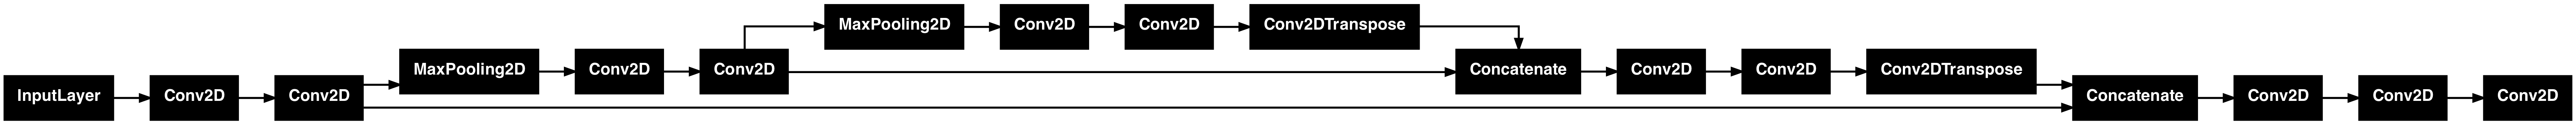

In [91]:
plot_model(model,
           to_file='model_reduced.png',
           show_shapes=False,      # Hide output shapes
           show_layer_names=False, # Hide layer names
  rankdir='LR')           # Layout from left-to-right

In [92]:
validation_image_paths = crop_and_convert('training.tif', 'validation_{0:04d}.png',step=20,crop_box=[512,256,768,512])
validation_mask_paths  = crop_and_convert('training_groundtruth.tif', 'validationGT_{0:04d}.png',step=20,crop_box=[512,256,768,512])

validation_dataset = tf.data.Dataset.from_tensor_slices((validation_image_paths, validation_mask_paths))
validation_dataset = validation_dataset.map(lambda img, msk: parse_image_function(img, msk),
                                  num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

In [93]:
# Train the model
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset)  # Ensure you have a validation dataset prepared similarly

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9207 - loss: 0.6748 - val_accuracy: 0.8961 - val_loss: 0.5809
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9208 - loss: 0.5763 - val_accuracy: 0.8961 - val_loss: 0.4311
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9208 - loss: 0.4169 - val_accuracy: 0.8961 - val_loss: 0.3134
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9208 - loss: 0.2527 - val_accuracy: 0.8961 - val_loss: 0.3922
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9208 - loss: 0.3046 - val_accuracy: 0.8961 - val_loss: 0.3034
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9208 - loss: 0.2476 - val_accuracy: 0.8961 - val_loss: 0.2899
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9208 - loss: 0.2464 - val_accuracy: 0.8961 - val_loss: 0.2893
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9208 - loss: 0.2480 - val_accuracy: 0.8961 - val_loss: 0.

In [94]:
def predict_segmentation(model, image_path, img_size=(128,128)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.expand_dims(image, axis=0)  # add batch dimension

    pred_mask = model.predict(image)[0]
    # For binary segmentation, threshold the prediction
    pred_mask = (pred_mask > 0.5).astype("uint8")
    return pred_mask

# Example usage:
predicted_mask = predict_segmentation(model, 'validation_0000.png')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


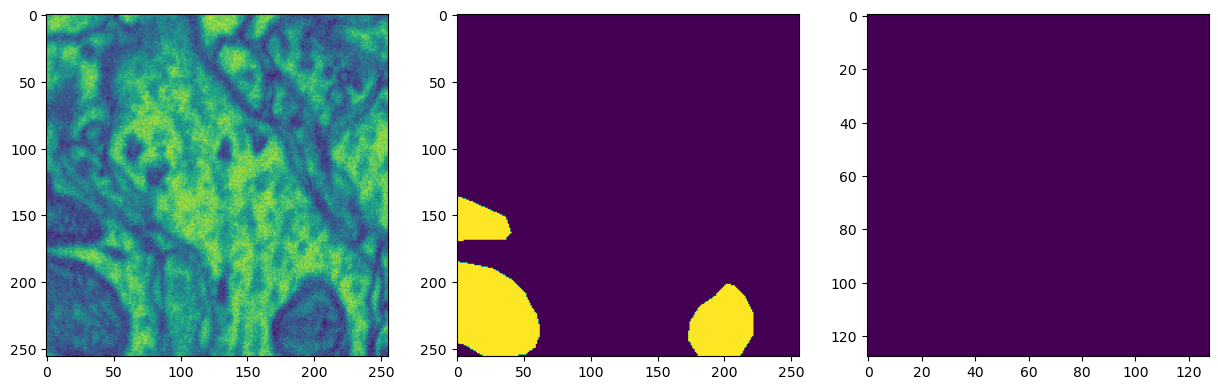

In [76]:
fig,ax= plt.subplots(1,3,figsize=(15,5))
img=plt.imread('validation_0000.png')
mask = plt.imread('validationGT_0000.png')
ax[0].imshow(img)
ax[1].imshow(mask)
ax[2].imshow(predicted_mask)

# A convolutional U-net

In [214]:
N=512
def unet_2d(input_shape=(N, N, 1), base_filters=32):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder: 4 levels
    c1 = conv_block(inputs, base_filters)            # Level 1
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

    c2 = conv_block(p1, base_filters * 2)            # Level 2
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

    c3 = conv_block(p2, base_filters * 4)            # Level 3
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

    c4 = conv_block(p3, base_filters * 8)            # Level 4 (bottom)

    # Decoder
    u3 = tf.keras.layers.Conv2DTranspose(base_filters * 4, 
                                         (2,2), strides=(2,2),
                                         padding='same')(c4)
    u3 = tf.keras.layers.concatenate([u3, c3])
    c5 = conv_block(u3, base_filters * 4)

    u2 = tf.keras.layers.Conv2DTranspose(base_filters * 2,
                                         (2,2), strides=(2,2),
                                         padding='same')(c5)
    u2 = tf.keras.layers.concatenate([u2, c2])
    c6 = conv_block(u2, base_filters * 2)

    u1 = tf.keras.layers.Conv2DTranspose(base_filters,
                                         (2,2), strides=(2,2),
                                         padding='same')(c6)
    u1 = tf.keras.layers.concatenate([u1, c1])
    c7 = conv_block(u1, base_filters)

    # Output: single channel, sigmoid activation
    outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c7)
    model = tf.keras.Model(inputs, outputs)
    return model

def conv_block(x, filters):
    x = tf.keras.layers.Conv2D(filters, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(filters, (3,3), activation='relu', padding='same')(x)
    return x


# Instantiate and compile the model
model = unet_2d()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
#               optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
              loss=['binary_crossentropy','dice'],  # change loss if needed (e.g., categorical_crossentropy for multi-class)
              metrics=['accuracy'])

# model.summary()

## Reload data to match new model

### Training

In [222]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
train_dataset = train_dataset.map(lambda img, msk: parse_image_function(img, msk,img_size=(N, N), channels=1),
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

### Validation

In [223]:
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_image_paths, validation_mask_paths))
validation_dataset = validation_dataset.map(lambda img, msk: parse_image_function(img, msk, img_size=(N, N), channels=1),
                                  num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

## Train the model

In [224]:
# Train the model
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset)  # Ensure you have a validation dataset prepared similarly

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step - accuracy: 0.0598 - conv2d_395_loss: 0.0000e+00 - loss: 0.6984 - val_accuracy: 0.0958 - val_conv2d_395_loss: 0.0000e+00 - val_loss: 0.6974
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step - accuracy: 0.0615 - conv2d_395_loss: 0.0000e+00 - loss: 0.6980 - val_accuracy: 0.0958 - val_conv2d_395_loss: 0.0000e+00 - val_loss: 0.6971
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step - accuracy: 0.0644 - conv2d_395_loss: 0.0000e+00 - loss: 0.6976 - val_accuracy: 0.0960 - val_conv2d_395_loss: 0.0000e+00 - val_loss: 0.6968
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step - accuracy: 0.0685 - conv2d_395_loss: 0.0000e+00 - loss: 0.6973 - val_accuracy: 0.0963 - val_conv2d_395_loss: 0.0000e+00 - val_loss: 0.6964
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step - accuracy: 0.0745 - conv2d_395_loss: 0.0000e+00 - loss: 0.6969 - val_accuracy: 0.0971 - val_conv2d_395_loss: 0.0000e+00 - val_loss: 0.6961
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


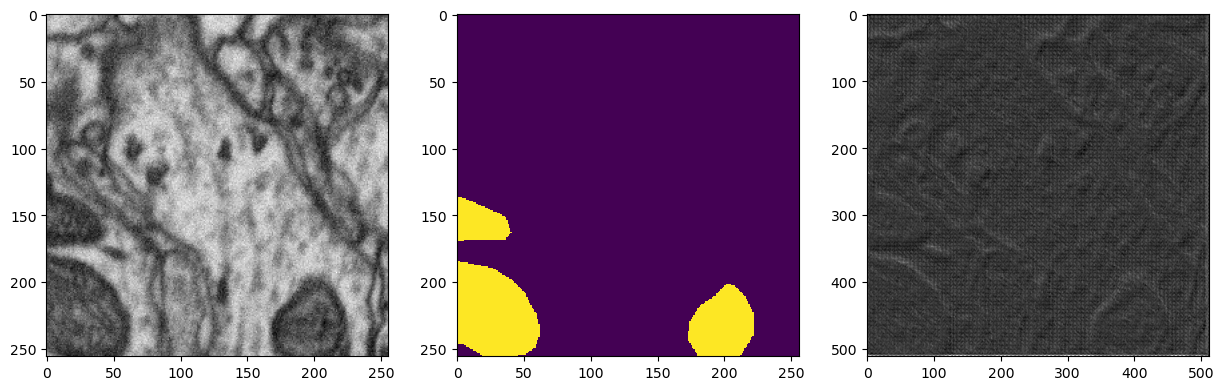

In [225]:
def predict_segmentation(model, image_path, img_size=(N,N)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.expand_dims(image, axis=0)  # add batch dimension

    pred_mask = model.predict(image)[0]
    # For binary segmentation, threshold the prediction
#     pred_mask = (pred_mask > 0.5).astype("uint8")
    return pred_mask

# Example usage:
predicted_mask = predict_segmentation(model, 'validation_0000.png')

fig,ax= plt.subplots(1,3,figsize=(15,5))
img=plt.imread('validation_0000.png')
mask = plt.imread('validationGT_0000.png')
ax[0].imshow(img,cmap='gray')
ax[1].imshow(mask,interpolation='none')
ax[2].imshow(predicted_mask,interpolation='none',cmap='gray')

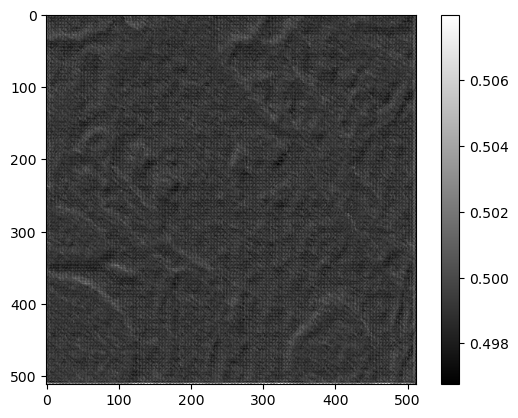

In [226]:
plt.imshow(predicted_mask,interpolation='none',cmap='gray')
plt.colorbar()

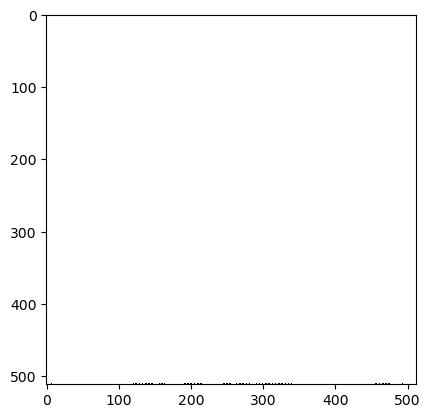

In [227]:
plt.imshow(predicted_mask<0.505,interpolation='none',cmap='gray')